In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import quickMTF.mtf as mtf
from quickMTF.mtf import SFR, cSFRSetttings

%matplotlib inline

In [2]:
plot = True
verbose = True

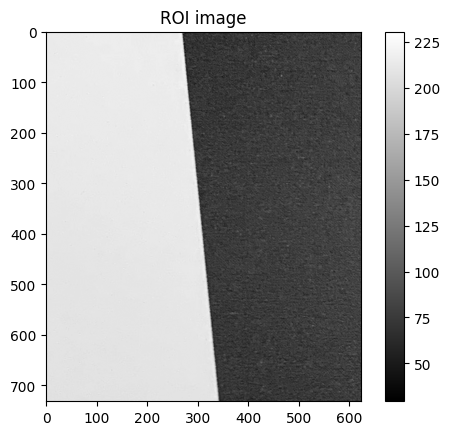

In [3]:
# load ROI image
image = np.load(r"..\quickMTF\sample_hori_edge.npy")
image = np.load(r"..\quickMTF\sample_vert_edge.npy")
# image = np.load(r"..\quickMTF\sample.npy")
# image = np.load(r"C:\Users\Lucas\Desktop\for\for Lucas\sample.npy")

sample = image

if plot:
    mtf.plot_roi_image(image)

In [4]:
sfr_settings = cSFRSetttings(
    super_sampling = 8,
    mtf_index = 0.5,
    # diff_kernel = np.array([1, 1, 1, 1, 1, 0.0, -1, -1, -1, -1, -1]) / 10,
    diff_kernel = np.array([0.5, 0.0, -0.5]),
    diff_offset = 0.0,
    diff_ft = 2,
    sequence = 0,
    show_plots = 5,
    return_fig = False
)

sfr = SFR(image, sfr_settings)
original_roi_info, rotated_roi_info, roi_info, esf_info, lsf_info, mtf_info, status_info = sfr.get_mtf()


rotated: False


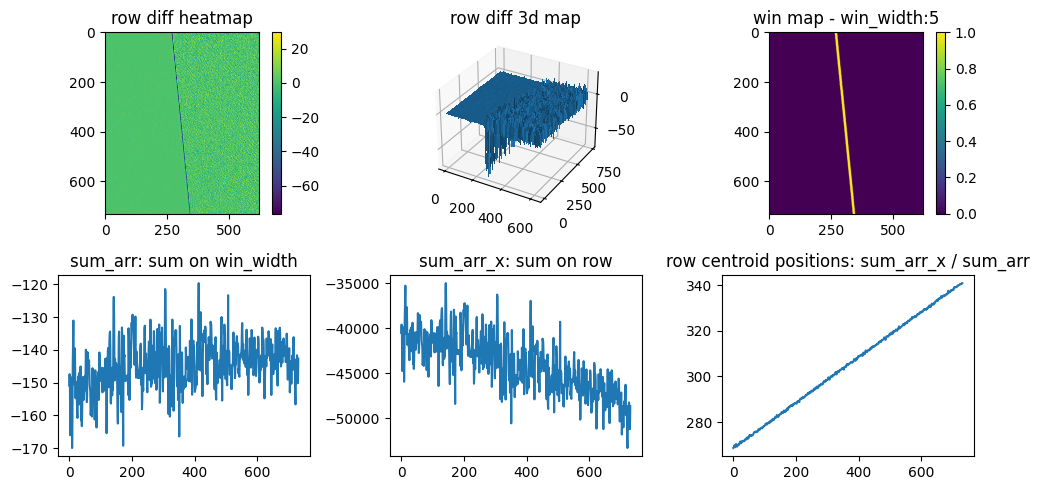

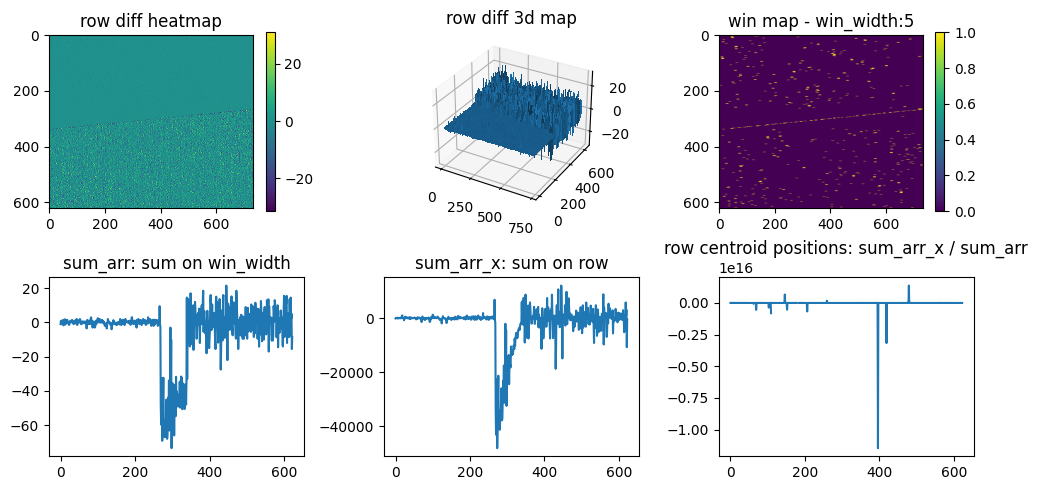

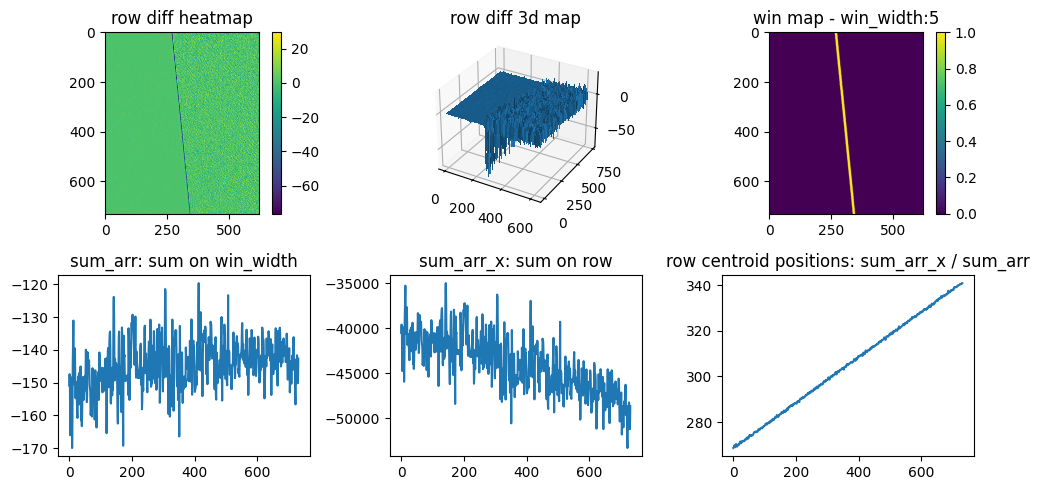

In [5]:
# plot centroids

if verbose:
    print(f"rotated: {roi_info.centroid_info.rotated}")

if plot:
    mtf.plot_centroid_and_stats(original_roi_info)

if plot:
    mtf.plot_centroid_and_stats(rotated_roi_info)

if plot:
    mtf.plot_centroid_and_stats(roi_info)

In [6]:
# pcoefs, slope, offset, angle, idx, patch_shape, centr = edge_info.
if verbose:
    print(f"pcoefs: {roi_info.edge_info.pcoefs}")
    print(f"slope: {roi_info.edge_info.slope}")
    print(f"angle: {roi_info.edge_info.angle}")
    print(f"idx: {roi_info.edge_info.idx}")
    print(f"patch_shape: {roi_info.edge_info.patch_shape}")
    # print(f"image_for_mtf.shape: {centroid_info.image_for_mtf.shape}")


pcoefs: [0.0, np.float64(0.0995274007572686), np.float64(268.5676612472539)]
slope: 0.0995274007572686
angle: 5.6837820413377145
idx: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 21

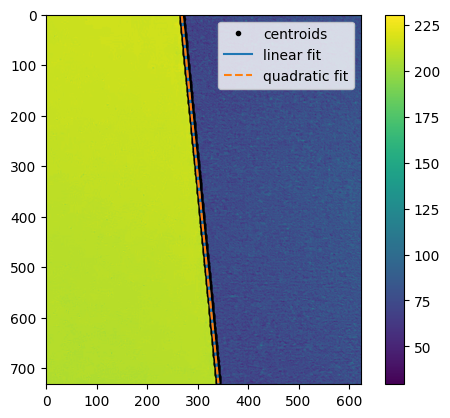

In [7]:
if plot:
    mtf.plot_edge_and_stats(roi_info.centroid_info.image_for_mtf, roi_info.edge_info.pcoefs, roi_info.edge_info.slope, roi_info.edge_info.offset, roi_info.edge_info.angle, roi_info.edge_info.idx, roi_info.edge_info.patch_shape, roi_info.edge_info.centr, roi_info.centroid_info.rotated)

dist.shape: (732, 623)


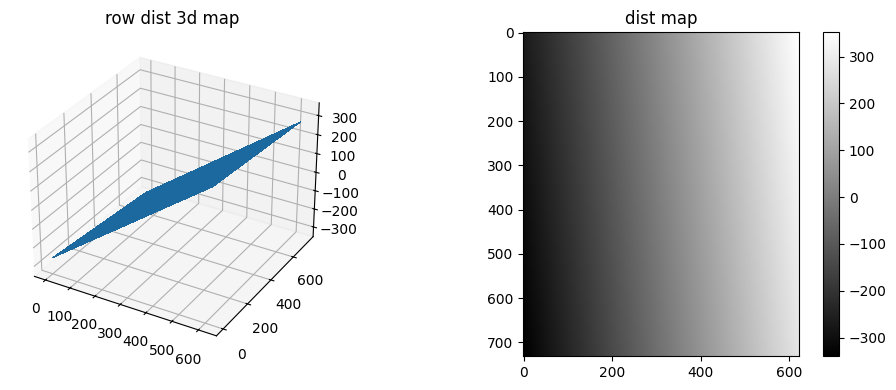

In [8]:
# Calculate distance (with sign) from each point (x, y) in the
# image patch "data" to the slanted edge
quadratic_fit = False
# dist = edge_info.dist
if verbose:
    print(f"dist.shape: {roi_info.edge_info.dist.shape}")

if plot:
    mtf.plot_dist_and_stats(roi_info.edge_info.dist)

esf.shape: (5532,)


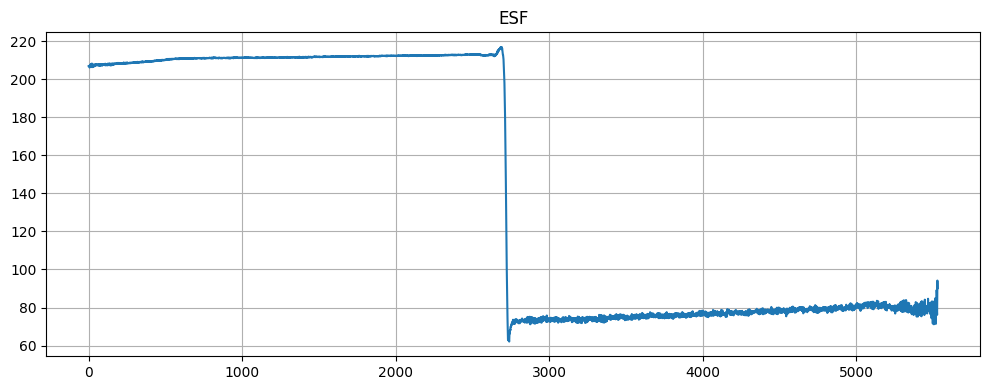

In [9]:
# ESF
if esf_info.esf is False:
    print("esf is invalid")

if verbose:
    print(f"esf.shape: {esf_info.esf.shape}")

if plot:
    mtf.plot_esf_and_stats(esf_info.esf)

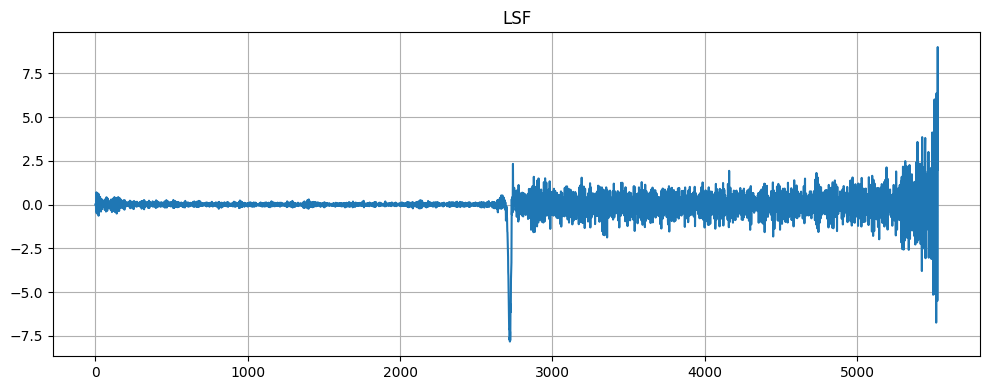

hann_width: 102
idx2: [2606, 2926]


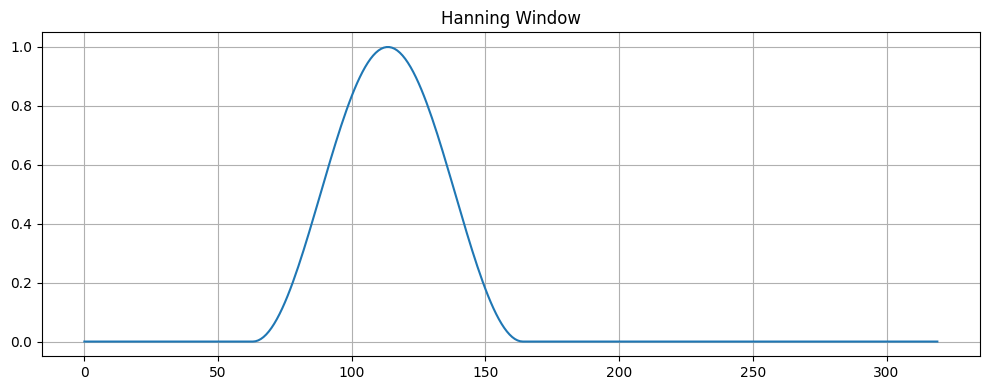

In [10]:
## LSF
if plot:
    mtf.plot_lsf_and_stats(lsf_info.lsf[0:-1])

## Hann window
window_info = lsf_info.window_info  # define window to be applied on LSF
if window_info.hann_width >350:  # sorting out no slant edge
    print("wrong!")

if verbose:
    print(f"hann_width: {window_info.hann_width}")
    print(f"idx2: {window_info.idx2}")

if plot:
    mtf.plot_filter_window_and_stats(window_info.hann_win)

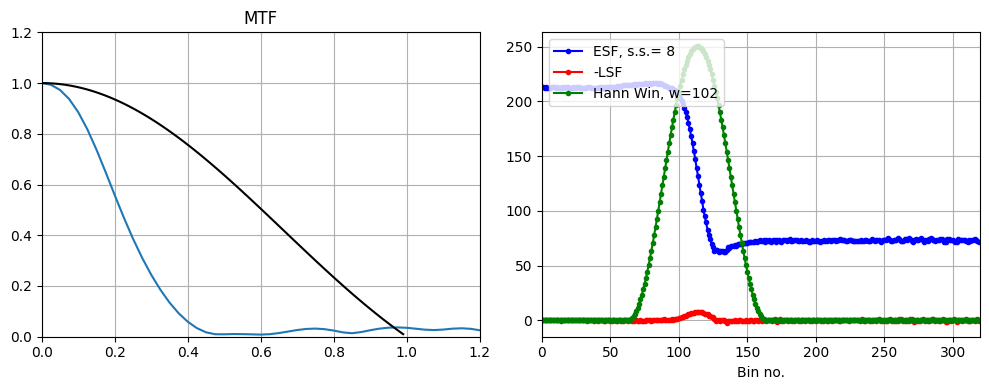

In [11]:
## MTF
## status
rotated, angle_cw, offset = status_info

mtf.plot_mtf_and_stats(mtf_info.mtf_result, esf_info.esf, window_info.hann_win, window_info.hann_width, lsf_info.lsf, window_info.idx2, esf_info.super_sampling)